<a href="https://colab.research.google.com/github/yuannnnn/DATS6501/blob/main/Disasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading & Processing

In [ ]:
import os

if "crisis_vision_benchmarks" not in os.listdir():
    os.system("wget https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz")
    os.system("tar xf crisis_vision_benchmarks.tar.gz")

In [ ]:
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.pre = os.getcwd() + "/crisis_vision_benchmarks"
        path = pd.read_csv(path, sep='\t')
        image_path, class_label = path['image_path'], path['class_label']
        self.img, lab = [], []
        for i in range(len(class_label)):
          if class_label[i] != 'other_disaster':
            self.img.append(image_path[i])
            lab.append(class_label[i])
        self.le = LabelEncoder()
        self.le.fit(lab)
        self.labels = self.le.transform(lab)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def le(self):
        return self.le

    def __getitem__(self, idx):
        img_path = os.path.join(self.pre, self.img[idx])
        with open(img_path, 'rb') as f:
          img = Image.open(f) 
          image = img.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop([299,299]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "dev": transforms.Compose([
        transforms.Resize([310,310]),
        transforms.CenterCrop([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

types_root = "/content/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_"

types_dataset = {x: CustomImageDataset(types_root + x + "_final.tsv", data_transforms[x])
                  for x in ["train", "dev"]}

types_loader = {x: DataLoader(types_dataset[x], batch_size=64,
                                             shuffle=True, num_workers=2)
                  for x in ["train", "dev"]}
              
types_size = {x: len(types_dataset[x]) for x in ["train", "dev"]}

types_names = types_dataset['train'].le.classes_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
types_test = CustomImageDataset(types_root + "test_final.tsv", data_transforms["dev"])

In [ ]:
len(types_dataset["train"]),len(types_dataset["dev"]),len(types_test)

(12846, 1470, 3195)

In [ ]:
types_names

array(['earthquake', 'fire', 'flood', 'hurricane', 'landslide',
       'not_disaster', 'other_disaster'], dtype=object)

In [ ]:
damage_names

array(['little_or_none', 'mild', 'severe'], dtype=object)

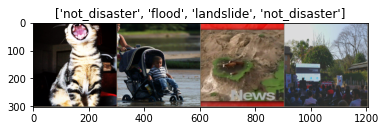

Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Change the Tensor to array and change color channel to the last
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(types_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[types_names[x] for x in classes[:4]])

print(f"Feature batch shape: {inputs.size()}")
print(f"Labels batch shape: {classes.size()}")

# Data Modeling & Training

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

In [ ]:
def train_types(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in types_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / types_size[phase]
            epoch_acc = running_corrects.double() / types_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms

In [ ]:
model_ft = models.inception_v3(pretrained=True)
model_ft

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model_ft

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(types_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
model_types = train_types(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.1414 Acc: 0.5903
dev Loss: 0.7241 Acc: 0.7732

Epoch 1/19
----------
train Loss: 0.6883 Acc: 0.7647
dev Loss: 0.5615 Acc: 0.8116

Epoch 2/19
----------
train Loss: 0.5724 Acc: 0.8047
dev Loss: 0.5152 Acc: 0.8199

Epoch 3/19
----------
train Loss: 0.5322 Acc: 0.8202
dev Loss: 0.4975 Acc: 0.8297

Epoch 4/19
----------
train Loss: 0.4960 Acc: 0.8311
dev Loss: 0.4706 Acc: 0.8440

Epoch 5/19
----------
train Loss: 0.4567 Acc: 0.8440
dev Loss: 0.4486 Acc: 0.8470

Epoch 6/19
----------
train Loss: 0.4417 Acc: 0.8499
dev Loss: 0.4645 Acc: 0.8425

Epoch 7/19
----------
train Loss: 0.4276 Acc: 0.8572
dev Loss: 0.4604 Acc: 0.8455

Epoch 8/19
----------
train Loss: 0.4292 Acc: 0.8559
dev Loss: 0.4487 Acc: 0.8531

Epoch 9/19
----------
train Loss: 0.4311 Acc: 0.8562
dev Loss: 0.4701 Acc: 0.8395

Epoch 10/19
----------
train Loss: 0.4244 Acc: 0.8569
dev Loss: 0.4492 Acc: 0.8515

Epoch 11/19
----------
train Loss: 0.4168 Acc: 0.8590
dev Loss: 0.4595 Acc: 0.8425

Epoch 12/19
----------
t

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

curr = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
torch.save(model_types.state_dict(), curr+"model_types2.pth")

# Load Trained Net

In [ ]:
model_ft = models.inception_v3(pretrained=False)
model_ft.aux_logits=False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(types_names))

model_ft.load_state_dict(torch.load(curr+"model_types2.pth"))

model_ft = model_ft.to(device)

In [ ]:
types_test = CustomImageDataset(types_root + "test_final.tsv", data_transforms["dev"])

test_loader = DataLoader(types_test, batch_size=64,
                                             shuffle=True, num_workers=2)

In [ ]:
preds, real = [], []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  real += labels.tolist()
  with torch.no_grad():
    output = model_ft(images)
    _, predicted = torch.max(output, 1)
    preds += predicted.tolist()

In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(real, preds, target_names=types_names))

              precision    recall  f1-score   support

  earthquake       0.88      0.81      0.84       404
        fire       0.89      0.90      0.89       280
       flood       0.86      0.89      0.88       599
   hurricane       0.76      0.69      0.73       352
   landslide       0.81      0.85      0.83       268
not_disaster       0.90      0.93      0.91       990

    accuracy                           0.86      2893
   macro avg       0.85      0.84      0.85      2893
weighted avg       0.86      0.86      0.86      2893



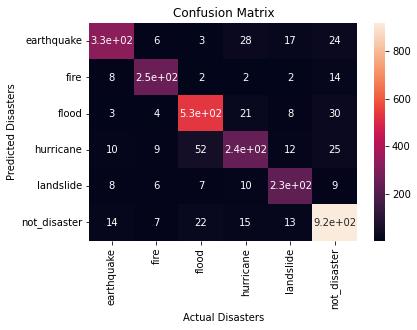

In [ ]:
import seaborn as sns

cm = metrics.confusion_matrix(real, preds)
f = sns.heatmap(cm, annot=True, xticklabels=types_names, yticklabels=types_names)
plt.title("Confusion Matrix")
plt.xlabel("Actual Disasters")
plt.ylabel("Predicted Disasters") 
plt.show()

# Codes borrowed and adjusted from:


1.  [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
2.  [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

